In [57]:
"""
This notebook will study how the number of previously completed sessions 
relates to the quality of embeddings/how well we are able to decode the labels used.
"""

'\nThis notebook will study how the number of previously completed sessions \nrelates to the quality of embeddings/how well we are able to decode the labels used.\n'

In [1]:
pip install cebra

  Using cached cebra-0.4.0-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached literate_dataclasses-0.0.6-py3-none-any.whl.metadata (2.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.0 MB/s eta 0:00:00
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.9 MB/s eta 0:00:00
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached urllib3-2.2.1-py3-none-any.whl.metadata (6.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
  Using cached filelock-3.14.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached cebra-0.4.0-py2.py3-none-any

In [3]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 16.2 MB/s eta 0:00:0000:0100:01
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
Note: you may need to restart the kernel to use updated packages.


In [36]:
import sys
import os # my addtion

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import utils
import seaborn as sns
from statistics import covariance
from scipy.stats import pearsonr

from matplotlib.collections import LineCollection
import pandas as pd

## A. Load the sessions stats dataframe

In [5]:
df_sessions_310_rpe = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/session_stats(rpe)_310.pkl', "rb"))

In [6]:
df_sessions_310_rpe[:100]

,subject_ID,ses_idx,all4_R2,DA_R2,NE_R2,5HT_R2,ACh_R2,b4_R2,af_R2
0,631198,631198_2022-07-13,0.041141,0.002456,0.051674,0.128383,0.107969,0.021773,0.366032
1,631198,631198_2022-07-14,0.077229,0.006450,0.095478,0.050001,0.094595,0.012253,0.045045
2,631198,631198_2022-07-20,0.274617,0.014499,0.032934,0.076755,0.086326,0.031454,0.231885
3,631198,631198_2022-07-21,0.395268,0.020262,0.108022,0.004124,0.133486,0.020923,0.399283
4,631198,631198_2022-07-22,0.276387,0.008862,0.069646,0.031648,0.034464,0.094729,0.187402
...,...,...,...,...,...,...,...,...,...
95,634704,634704_2022-09-14,0.658878,0.703689,0.582563,0.135360,0.550120,0.179323,0.699036
96,634704,634704_2022-09-15,0.662346,0.504903,0.567059,0.019956,0.528949,0.281684,0.600472
97,634704,634704_2022-09-16,0.606089,0.561648,0.442175,0.259604,0.574279,0.111735,0.615098
98,634704,634704_2022-09-19,0.143643,0.174070,0.019209,0.037848,0.013740,0.043510,0.018569


## B. Add column showing number of previously completed sessions

In [7]:
df_sessions_310_rpe['ses_idx_count'] = df_sessions_310_rpe.groupby('subject_ID').cumcount() + 1

In [8]:
df_sessions_310_rpe[:100]

,subject_ID,ses_idx,all4_R2,DA_R2,NE_R2,5HT_R2,ACh_R2,b4_R2,af_R2,ses_idx_count
0,631198,631198_2022-07-13,0.041141,0.002456,0.051674,0.128383,0.107969,0.021773,0.366032,1
1,631198,631198_2022-07-14,0.077229,0.006450,0.095478,0.050001,0.094595,0.012253,0.045045,2
2,631198,631198_2022-07-20,0.274617,0.014499,0.032934,0.076755,0.086326,0.031454,0.231885,3
3,631198,631198_2022-07-21,0.395268,0.020262,0.108022,0.004124,0.133486,0.020923,0.399283,4
4,631198,631198_2022-07-22,0.276387,0.008862,0.069646,0.031648,0.034464,0.094729,0.187402,5
...,...,...,...,...,...,...,...,...,...,...
95,634704,634704_2022-09-14,0.658878,0.703689,0.582563,0.135360,0.550120,0.179323,0.699036,9
96,634704,634704_2022-09-15,0.662346,0.504903,0.567059,0.019956,0.528949,0.281684,0.600472,10
97,634704,634704_2022-09-16,0.606089,0.561648,0.442175,0.259604,0.574279,0.111735,0.615098,11
98,634704,634704_2022-09-19,0.143643,0.174070,0.019209,0.037848,0.013740,0.043510,0.018569,12


## C. Make comparisons of the sessions stats with the ses_idx

Make a simple comparison plot.
Use a colour bar with the session summary plots and check if there's an observable trend.


In [9]:
df_sessions_310_rpe['DA_R2'].describe()

count    205.000000
mean       0.451302
std        0.202171
min        0.002456
25%        0.310002
50%        0.506397
75%        0.617148
max        0.737811
Name: DA_R2, dtype: float64

NameError: name 'axis' is not defined

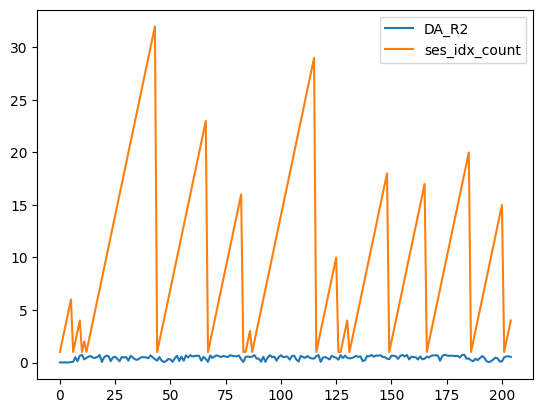

In [10]:
df_sessions_310_rpe[['DA_R2','ses_idx_count']].plot()
axis.xlabel('session number')
plt.ylabel('Completed sessions/Reconstruction score')
plt.title('Comparing # sessions done and reconstruction scores')

Text(0.5, 1.0, 'Does learning affect the encoding of rpe in DA?')

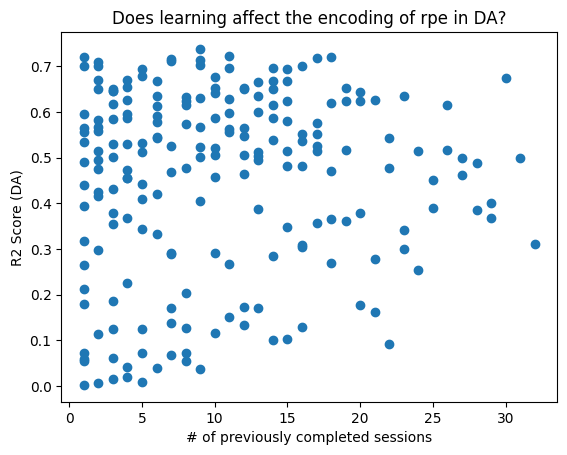

In [11]:
plt.plot(df_sessions_310_rpe['ses_idx_count'], df_sessions_310_rpe['DA_R2'], 'o')
plt.xlabel('# of previously completed sessions')
plt.ylabel('R2 Score (DA)')
plt.title('Does learning affect the encoding of rpe in DA?')

## D. Make summary plot for all the NMS, individually and collectively

In [12]:
# funciton to make the raw plot
def plot_r2_vs_sessions_raw(df, NM):
    # raw plot
    df[['{}_R2'.format(NM), 'ses_idx_count']].plot()
    plt.xlabel('session number')
    plt.ylabel('Completed sessions/Reconstruction score')
    plt.title('Comparing # sessions done and reconstruction scores ({})'.format(NM))
    

In [13]:
def plot_r2_vs_sessions(df, NM_list):

    # create a figure and make the plots
    fig1 = plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(2, 2, figure=fig1)

    ax1 = fig1.add_subplot(gs[0,0])
    ax2 = fig1.add_subplot(gs[0,1])
    ax3 = fig1.add_subplot(gs[1,0])
    ax4 = fig1.add_subplot(gs[1,1])
    axes = [ax1, ax2, ax3, ax4]
    
    colors = ['bo', 'go', 'ro', 'ko']

    for axis,NM,color in zip(axes, NM_list, colors):

        # trend plot
        axis.plot(df['ses_idx_count'], df['{}_R2'.format(NM)], color)
        axis.set_xlabel('# of previously completed sessions')
        axis.set_ylabel('R2 Score ({})'.format(NM))
        axis.set_title('Does learning affect the encoding of rpe in {}?'.format(NM))
    
    plt.tight_layout()


### 1. Plot the individual NMs data

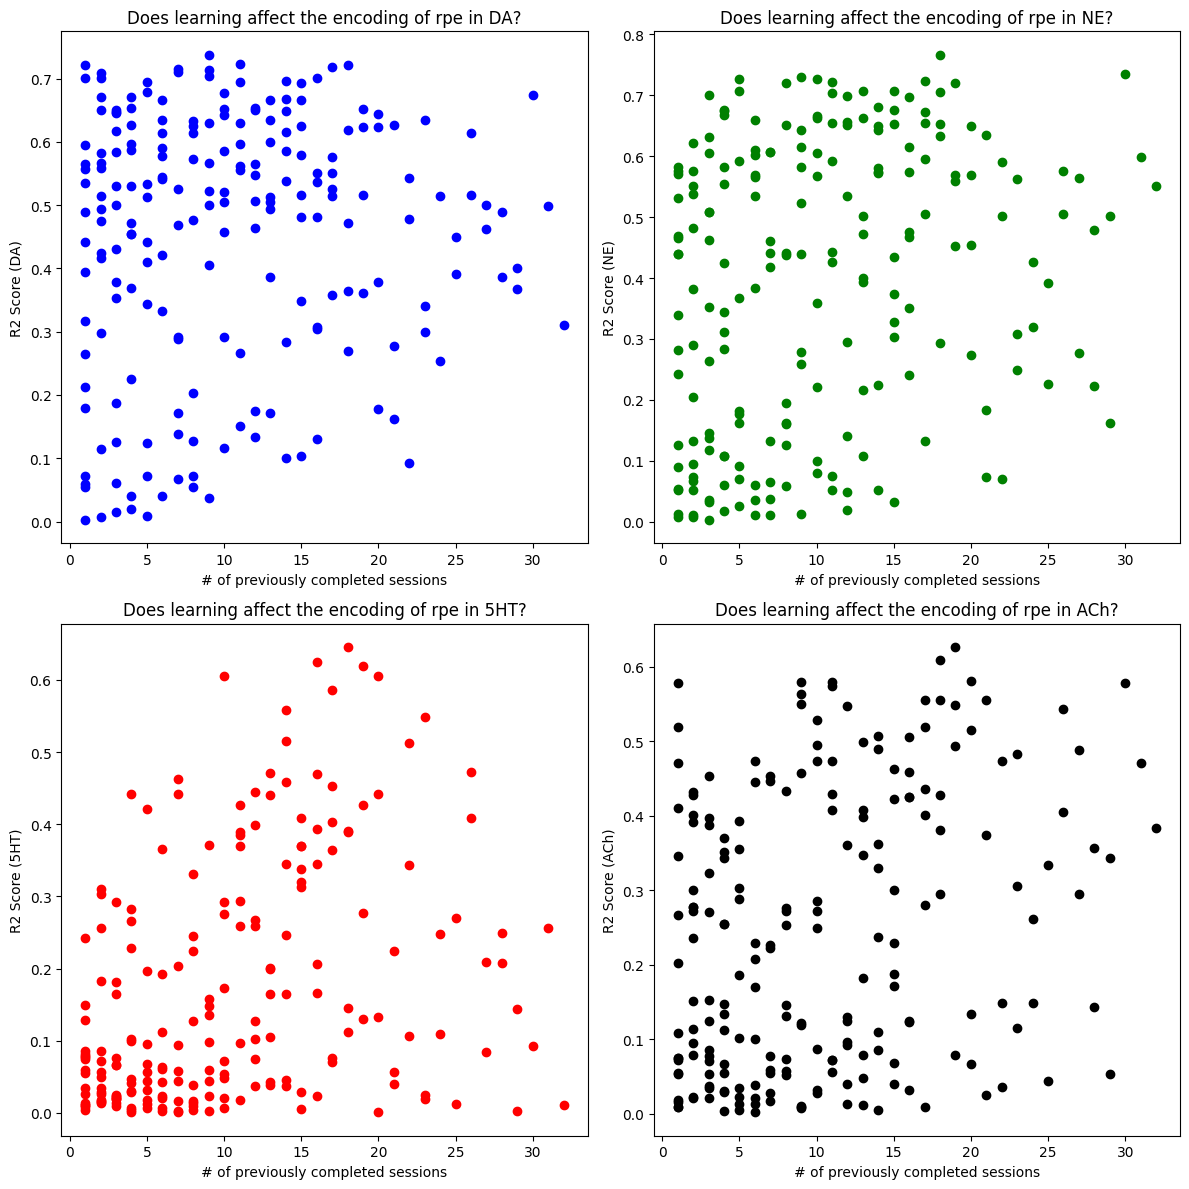

In [14]:
plot_r2_vs_sessions(df_sessions_310_rpe,['DA', 'NE', '5HT', 'ACh'])

### 2. Plot all NMs together

Text(0.5, 1.0, 'Does learning affect the encoding of rpe in different NMs?')

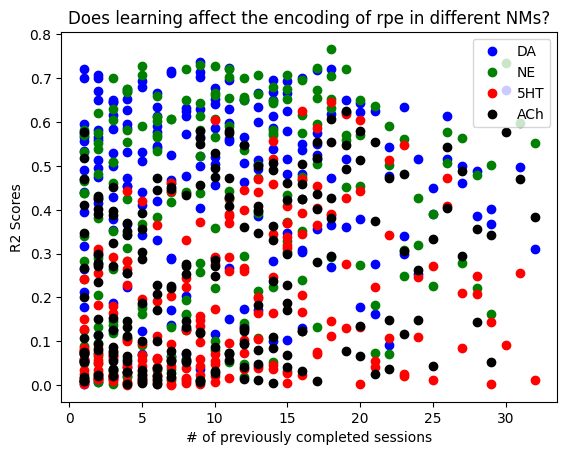

In [15]:
# combined plot
plt.plot(df_sessions_310_rpe['ses_idx_count'], df_sessions_310_rpe['DA_R2'],'bo', label='DA')
plt.plot(df_sessions_310_rpe['ses_idx_count'], df_sessions_310_rpe['NE_R2'],'go' ,label='NE')
plt.plot(df_sessions_310_rpe['ses_idx_count'], df_sessions_310_rpe['5HT_R2'],'ro', label='5HT')
plt.plot(df_sessions_310_rpe['ses_idx_count'], df_sessions_310_rpe['ACh_R2'], 'ko', label='ACh')

plt.xlabel('# of previously completed sessions')
plt.ylabel('R2 Scores')
plt.legend()
plt.title('Does learning affect the encoding of rpe in different NMs?')


Text(0.5, 1.0, 'Does learning affect the encoding of rpe in the Neuromodulators?')

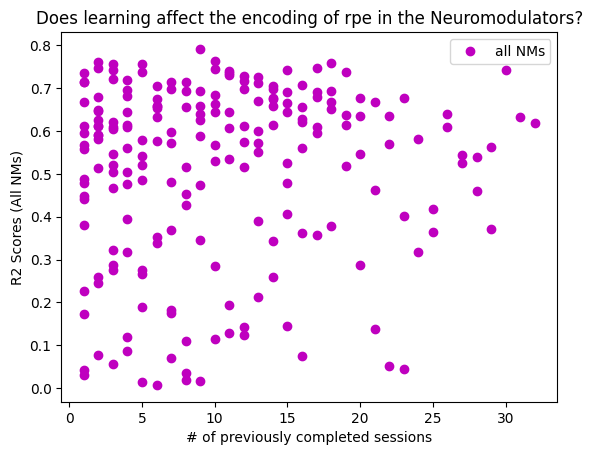

In [16]:
# plot the reconstruction scores for the combined embeddings
plt.plot(df_sessions_310_rpe['ses_idx_count'], df_sessions_310_rpe['all4_R2'],'mo', label='all NMs')

plt.xlabel('# of previously completed sessions')
plt.ylabel('R2 Scores (All NMs)')
plt.legend()
plt.title('Does learning affect the encoding of rpe in the Neuromodulators?')

## E. Quantify the correlation

In [17]:
np.cov(df_sessions_310_rpe['ses_idx_count'],df_sessions_310_rpe['ses_idx_count'])

array([[58.53452893, 58.53452893],
       [58.53452893, 58.53452893]])

Pearson correlation == covariance /product of the standard deviation of the two variables

In [32]:
covariance(df_sessions_310_rpe['ses_idx_count'], df_sessions_310_rpe['ses_idx_count'])/(np.std(df_sessions_310_rpe['ses_idx_count'])**2)

1.0049019607843137

In [35]:
# define function to compute the Pearson correlation
def get_correlation_coeff(x,y):
    return pearsonr(x,y)

In [43]:
# define loop to make comparisons over all the variables with the number of sessions

elements = ['DA_R2', 'NE_R2', '5HT_R2', 'ACh_R2']
coeffs = []

for element in elements:
    correlation, p_value = get_correlation_coeff(df_sessions_310_rpe[element], df_sessions_310_rpe['ses_idx_count'])
    coeffs.append(correlation)

coeffs = np.array(coeffs)

Text(0.5, 1.0, 'Comparison of the correlation coefficients')

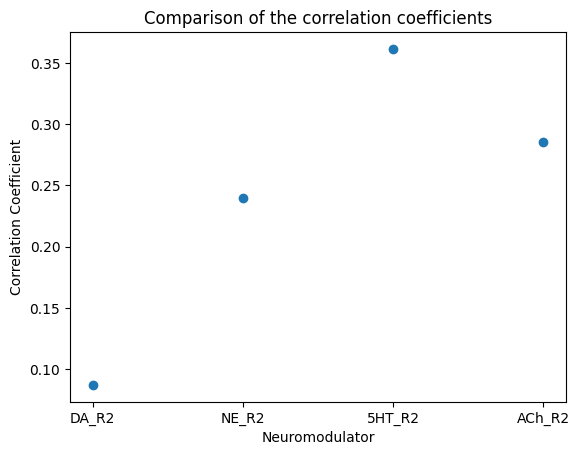

In [46]:
plt.plot(elements,coeffs,'o')
plt.xlabel('Neuromodulator')
plt.ylabel('Correlation Coefficient')
plt.title('Comparison of the correlation coefficients')

In [27]:
# DA covariance:
covariance(df_sessions_310_rpe['DA_R2'], df_sessions_310_rpe['DA_R2'])

0.04087312817095512

In [28]:
# NE covariance:
covariance(df_sessions_310_rpe['NE_R2'], df_sessions_310_rpe['NE_R2'])

0.054738780074040434

In [29]:
# 5HT covariance:
covariance(df_sessions_310_rpe['5HT_R2'], df_sessions_310_rpe['5HT_R2'])

0.02862639593031902

In [31]:
# ACh covariance:
covariance(df_sessions_310_rpe['ACh_R2'], df_sessions_310_rpe['DA_R2'])

0.020866826213821927

In [ ]:
# get the reconstruction score for a linear regression model fit to a straight line y=x

covariance()

In [19]:
df_sessions_310_rpe['ses_idx_count'].shape

(205,)

In [24]:
DA_coords = np.transpose(np.array((df_sessions_310_rpe['ses_idx_count'], df_sessions_310_rpe['DA_R2'])))

In [26]:
DA_coords

array([[1.00000000e+00, 2.45605114e-03],
       [2.00000000e+00, 6.45024500e-03],
       [3.00000000e+00, 1.44993582e-02],
       [4.00000000e+00, 2.02616231e-02],
       [5.00000000e+00, 8.86234501e-03],
       [6.00000000e+00, 3.98501346e-02],
       [1.00000000e+00, 7.15434669e-02],
       [2.00000000e+00, 4.94519306e-01],
       [3.00000000e+00, 1.25088409e-01],
       [4.00000000e+00, 6.53813966e-01],
       [1.00000000e+00, 7.21167313e-01],
       [2.00000000e+00, 2.97226621e-01],
       [1.00000000e+00, 4.40976889e-01],
       [2.00000000e+00, 5.59233585e-01],
       [3.00000000e+00, 6.17147981e-01],
       [4.00000000e+00, 4.54678015e-01],
       [5.00000000e+00, 4.41461625e-01],
       [6.00000000e+00, 5.45041234e-01],
       [7.00000000e+00, 7.10954351e-01],
       [8.00000000e+00, 5.49862174e-02],
       [9.00000000e+00, 5.00555196e-01],
       [1.00000000e+01, 6.52300447e-01],
       [1.10000000e+01, 5.96909472e-01],
       [1.20000000e+01, 1.34198568e-01],
       [1.300000